In [80]:
import numpy as np
import networkx as nx
import tsplib95
import matplotlib.pyplot as plt
import plotnine as p9
import json

from ortools.linear_solver import pywraplp
from pathlib import Path

In [2]:
def plot_solution(solution, n):
    S = nx.from_numpy_array(np.array(solution).reshape(n, n))
    pos = nx.spectral_layout(S)
    nx.draw(S, pos)
    nx.draw_networkx_labels(S, pos)

In [4]:
class ATSP:
    def __init__(self, formulation="SSB", linear_relaxation=False):

        self.formulation = formulation
        self.linear_relaxation = linear_relaxation
        self.status = None
        self.objective = None
        self.solve_time =None
        self.solution = None
        self.n = None
        self.C = None
        self.name = None

    def read(self, path):

        problem = tsplib95.load(path)
        G = problem.get_graph()
        self.name = problem.name
        self.C = nx.to_numpy_array(G)
        self.n = len(self.C)
        return self

    def save(self, dir):

        problem_solution = {
            "formulation": self.formulation,
            "name": self.name,
            "linear_relaxation": self.linear_relaxation,
            "n": self.n,
            "status": self.status,
            "objective": self.objective,
            "solve_time": self.solve_time,
            "solution": self.solution,
        }

        kind = ["integer", "linear_relaxation"][self.linear_relaxation]
             
        filename = dir + "_".join([self.name, self.formulation, kind]) + ".json"

        with open(filename, "w") as f:
            json.dump(problem_solution, f) 
                
        return self

    def solve(self):

        s = pywraplp.Solver.CreateSolver(self.formulation, "CBC")

        inf = s.infinity()

        if self.linear_relaxation:
            x = [[s.NumVar(0, 1, f"x[{i}, {j}]") for i in range(self.n)] for j in range(self.n)]
        else:
            x = [[s.BoolVar(f"x[{i}, {j}]") for i in range(self.n)] for j in range(self.n)]

        for i in range(self.n):
            s.Add(1 == s.Sum(x[i][j] for j in range(self.n)))
            s.Add(1 == s.Sum(x[j][i] for j in range(self.n)))
            #s.Add(0 == x[i][i])

        if self.formulation == "MTZ":

            u = [s.NumVar(0, inf, f"u[{i}]") for i in range(self.n)]

            for i in range(1, self.n):
                for j in range(1, self.n):
                    s.Add(u[i] - u[j] + (self.n - 1) * x[i][j] <= self.n - 2)
                    
        else:

            d = [[s.NumVar(0, inf, f"d[{i}, {j}]") for i in range(self.n)] for j in range(self.n)]

            for i in range(1, self.n):
                for j in range(1, self.n):
                    s.Add(d[i][j] - x[i][j] >= 0)
                    if i != j:
                        s.Add(d[i][j] + d[j][i] == 1)

            for i in range(1, self.n):
                for j in range(1, self.n):
                    for k in range(1, self.n):
                        s.Add(x[i][j] + d[j][k] + x[k][j] + d[k][i] + x[i][k] <= 2)

            for j in range(1, self.n):
                s.Add(x[0][j] + x[j][0] <= 1)

        s.Minimize(s.Sum(self.C[i][j] * x[i][j] for i in range(self.n) for j in range(self.n)))
        s.SetNumThreads(3)

        if not self.linear_relaxation:
            s.set_time_limit(7200000)

        self.status = s.Solve()
        self.objective = s.Objective().Value()
        self.solve_time = s.wall_time()
        self.solution = [x[i][j].solution_value() for i in range(self.n) for j in range(self.n)]

        return self

In [21]:
files = Path("data").glob("*.atsp")

for f in files:
    ATSP("MTZ", linear_relaxation=True).read(f).solve().save("solutions/")
    ATSP("SSB", linear_relaxation=True).read(f).solve().save("solutions/")
    ATSP("MTZ").read(f).solve().save("solutions/")
    ATSP("SSB").read(f).solve().save("solutions/")

In [94]:
files = Path("./solutions").glob("*json")

data = {}
for f in files:
    with open(f, "r") as file:
        data[str(f)] = json.load(file)

In [117]:
sol_df[["solve_time"]].round()

,solve_time
solutions/ftv55_SSB_linear_relaxation.json,0.358417
solutions/ftv55_SSB_integer.json,100.589
solutions/ftv38_SSB_linear_relaxation.json,0.0481333
solutions/ftv170_MTZ_linear_relaxation.json,0.0326
solutions/ftv170_SSB_linear_relaxation.json,65.0225
solutions/ftv38_MTZ_integer.json,0.199183
solutions/ftv170_MTZ_integer.json,44.3629
solutions/ftv38_MTZ_linear_relaxation.json,0.00153333
solutions/ftv55_MTZ_integer.json,0.696017
solutions/ftv55_MTZ_linear_relaxation.json,0.0041


In [169]:
sol_df = pd.DataFrame(data).T
#.assign(solve_time=lambda df: df["solve_time"] / (1000*60*60)))
#sol_df["solve_time"] = sol_df["solve_time"].astype("float").round(4)
sol_df

,formulation,name,linear_relaxation,n,status,objective,solve_time,solution
solutions/ftv55_SSB_linear_relaxation.json,SSB,ftv55,True,56,0,1570.5,21505,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
solutions/ftv55_SSB_integer.json,SSB,ftv55,False,56,1,4697,6035368,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
solutions/ftv38_SSB_linear_relaxation.json,SSB,ftv38,True,39,0,1513.89,2888,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
solutions/ftv170_MTZ_linear_relaxation.json,MTZ,ftv170,True,171,0,2631.48,1956,"[0.0, 0.0, 0.0, 0.9882352941176471, 0.0, 0.0, ..."
solutions/ftv170_SSB_linear_relaxation.json,SSB,ftv170,True,171,0,2715.4,3901350,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
solutions/ftv38_MTZ_integer.json,MTZ,ftv38,False,39,0,1530,11951,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
solutions/ftv170_MTZ_integer.json,MTZ,ftv170,False,171,1,2777,2661772,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
solutions/ftv38_MTZ_linear_relaxation.json,MTZ,ftv38,True,39,0,1440.21,92,"[0.0, 0.06578947368421073, 0.0, 0.0, 0.0, 0.0,..."
solutions/ftv55_MTZ_integer.json,MTZ,ftv55,False,56,0,1608,41761,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
solutions/ftv55_MTZ_linear_relaxation.json,MTZ,ftv55,True,56,0,1438.29,246,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


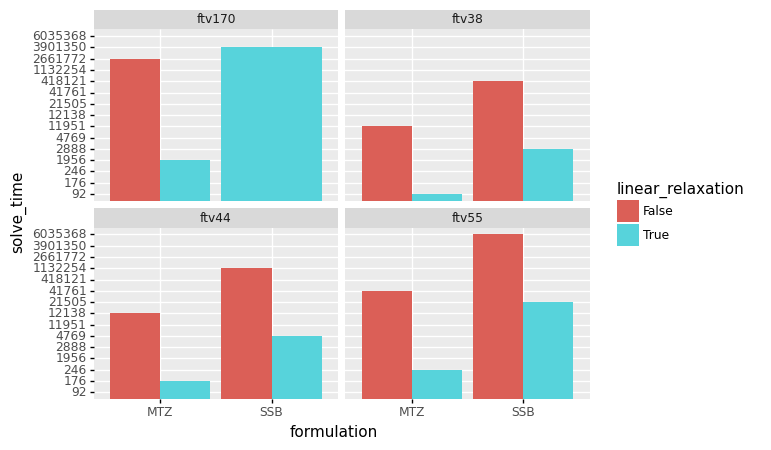

<ggplot: (8753569960649)>

In [170]:
(p9.ggplot(sol_df) +
    p9.aes("formulation", "solve_time", fill="linear_relaxation") +
    p9.geom_col(position="dodge") +
    p9.facet_wrap("name"))

In [165]:
sol_df.query("linear_relaxation ==  False").groupby("formulation")["solve_time"].mean()

formulation
MTZ    0.189425
SSB    0.702367
Name: solve_time, dtype: float64